# CycleGAN
* source of inspiration: https://github.com/NitishaS-812k/Monet-CycleGAN/blob/master/cyclegan.ipynb

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import re
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [3]:
# Get the path to the file in the "photo" directory
PHOTO_FILENAMES = tf.io.gfile.glob(r'E:\ual\photo\*.jpg')
print('Photo:', len(PHOTO_FILENAMES))

Photo: 4318


In [4]:
# Get the path to the file in the "train_monet" directory.
Chinese_landscape_FILENAMES = tf.io.gfile.glob(r'E:\ual\chinese landscape painting\*.jpg')
print('chinese landscape painting:', len(Chinese_landscape_FILENAMES))

chinese landscape painting: 2192


In [5]:

IMAGE_SIZE = (256, 256)
# Define image processing functions
def decode_image(image):
    image = tf.io.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.image.resize(image, IMAGE_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])

    return image

## Load Chinese landscape style and photo datasets
Chinese_landscape_datagen = tf.data.Dataset.list_files(r'E:\ual\chinese landscape painting\*.jpg')
photo_datagen = tf.data.Dataset.list_files(r'E:\ual\photo\*.jpg')

# Handling Chinese landscape style and photo datasets
Chinese_landscape_ds = Chinese_landscape_datagen.map(lambda x: decode_image(tf.io.read_file(x))).batch(4)
photo_ds = photo_datagen.map(lambda x: decode_image(tf.io.read_file(x))).batch(4)

In [6]:
def load_dataset(img_path, labeled=True, ordered=False):
    dataset = tf.data.Dataset.list_files(img_path)
    dataset = dataset.map(lambda x: process(x))
    return dataset

In [7]:
def process(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

In [8]:
Chinese_landscape_datagen = tf.data.Dataset.list_files(r'E:\ual\chinese landscape painting\*.jpg')
photo_datagen = tf.data.Dataset.list_files(r'E:\ual\photo\*.jpg')


Chinese_landscape_ds = Chinese_landscape_datagen.map(lambda x: process(x)).batch(4)

photo_ds = photo_datagen.map(lambda x: process(x)).batch(4)

In [9]:
example_monet = next(iter(Chinese_landscape_ds))
example_photo = next(iter(photo_ds))

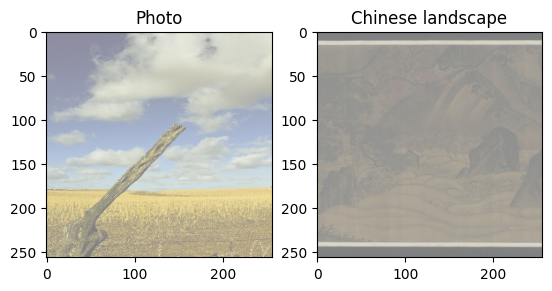

In [10]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0]* 0.5 + 0.5)

plt.subplot(122)
plt.title('Chinese landscape')
plt.imshow(example_monet[0]* 0.5 + 0.5)

In [11]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [12]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [15]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), 
        downsample(128, 4), 
        downsample(256, 4), 
        downsample(512, 4), 
        downsample(512, 4),
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4), 
        upsample(256, 4),
        upsample(128, 4), 
        upsample(64, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') 

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [16]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2) 

    zero_pad1 = layers.ZeroPadding2D()(down3) 
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) 

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) 

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) 

    return tf.keras.Model(inputs=inp, outputs=last)

In [17]:
class CycleGan(keras.Model):
    def __init__(
        self,
        Chinese_landscape_generator,
        photo_generator,
        Chinese_landscape_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.c_gen = Chinese_landscape_generator
        self.p_gen = photo_generator
        self.c_disc = Chinese_landscape_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        c_gen_optimizer,
        p_gen_optimizer,
        c_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.c_gen_optimizer = c_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.c_disc_optimizer = c_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_Chinese_landscape, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to Chinese landscape back to photo
            fake_Chinese_landscape = self.c_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_Chinese_landscape, training=True)

            # Chinese landscape to photo back to Chinese landscape
            fake_photo = self.p_gen(real_Chinese_landscape, training=True)
            cycled_Chinese_landscape = self.c_gen(fake_photo, training=True)

            # generating itself
            same_Chinese_landscape = self.c_gen(real_Chinese_landscape, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputting real images
            disc_real_Chinese_landscape = self.c_disc(real_Chinese_landscape, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputting fake images
            disc_fake_Chinese_landscape = self.c_disc(fake_Chinese_landscape, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            Chinese_landscape_gen_loss = self.gen_loss_fn(disc_fake_Chinese_landscape)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_Chinese_landscape, cycled_Chinese_landscape, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_Chinese_landscape_gen_loss = Chinese_landscape_gen_loss + total_cycle_loss + self.identity_loss_fn(real_Chinese_landscape, same_Chinese_landscape, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            Chinese_landscape_disc_loss = self.disc_loss_fn(disc_real_Chinese_landscape, disc_fake_Chinese_landscape)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        Chinese_landscape_generator_gradients = tape.gradient(total_Chinese_landscape_gen_loss, self.c_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        Chinese_landscape_discriminator_gradients = tape.gradient(Chinese_landscape_disc_loss, self.c_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.c_gen_optimizer.apply_gradients(zip(Chinese_landscape_generator_gradients, self.c_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.c_disc_optimizer.apply_gradients(zip(Chinese_landscape_discriminator_gradients, self.c_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))

        return {
            "Chinese_landscape_gen_loss": total_Chinese_landscape_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "Chinese_landscape_disc_loss": Chinese_landscape_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }




In [18]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [19]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [20]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [21]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [22]:
Chinese_landscape_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Chinese_landscape_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
Chinese_landscape_generator = Generator()
photo_generator = Generator()

In [24]:
Chinese_landscape_discriminator = Discriminator()
photo_discriminator = Discriminator()

In [25]:
cycle_gan_model = CycleGan(
   Chinese_landscape_generator, photo_generator, Chinese_landscape_discriminator, photo_discriminator
)

In [26]:
cycle_gan_model.compile(
    Chinese_landscape_generator_optimizer,
    photo_generator_optimizer,
    Chinese_landscape_discriminator_optimizer,
    photo_discriminator_optimizer,
    generator_loss,
    discriminator_loss,
    calc_cycle_loss,
    identity_loss
)

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((Chinese_landscape_ds, photo_ds)),
    epochs=100
)

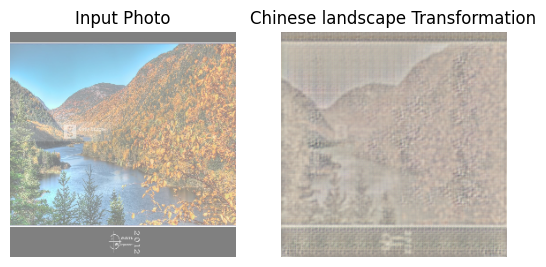

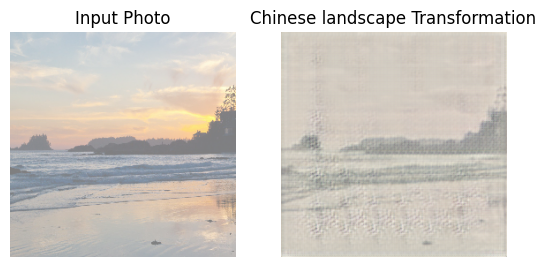

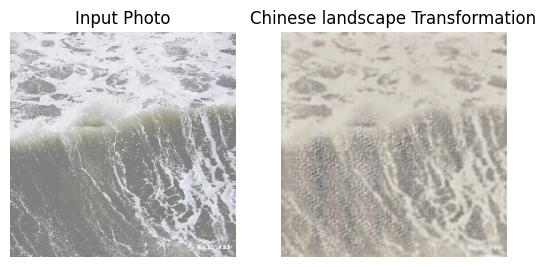

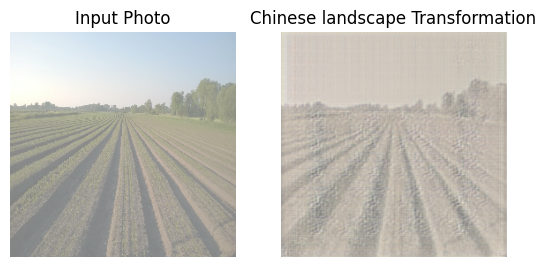

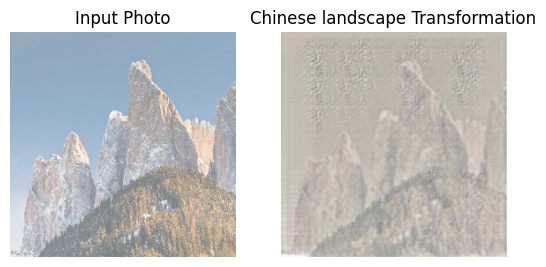

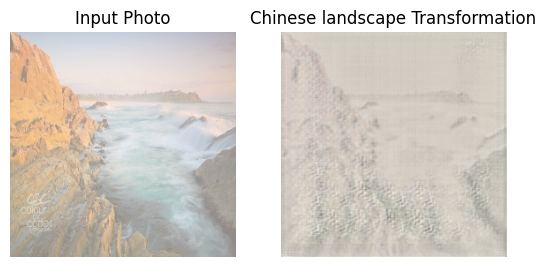

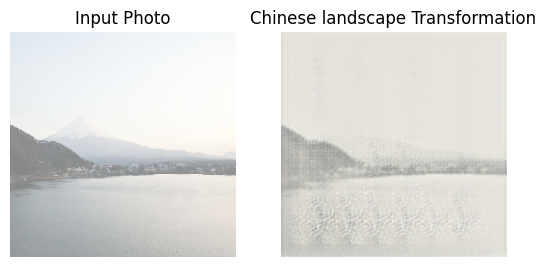

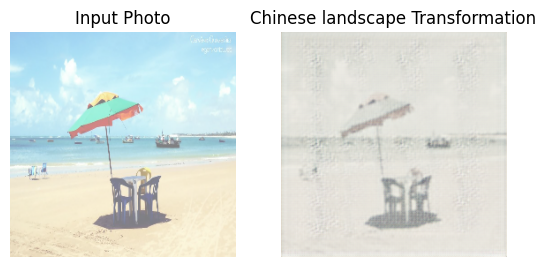

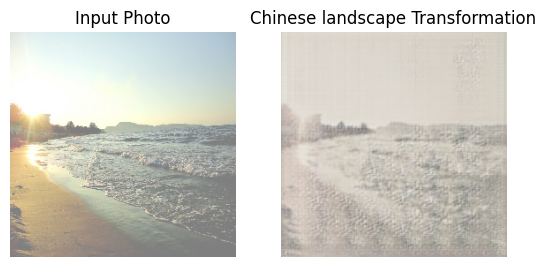

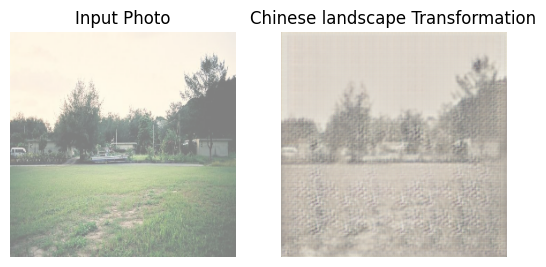

In [36]:

import os
import matplotlib.pyplot as plt
from PIL import Image

# Make sure the output folder exists
output_folder = r"E:\ual\out Chinese landscape painting"
os.makedirs(output_folder, exist_ok=True)

j = 0
for i, img in enumerate(photo_ds.take(10)):
    prediction = Chinese_landscape_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Photo")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(prediction)
    plt.title("Chinese landscape Transformation")
    plt.axis("off")

    # Saving the original image
    Image.fromarray(img).save(os.path.join(output_folder, f'prediction_{i+j}_original.jpg'), quality=95)

    # Save the generated prediction image
    Image.fromarray(prediction).save(os.path.join(output_folder, f'prediction_{i+j}.jpg'), quality=95)
    
    plt.show()

    j += 10

